# E.Coli timeseries

This notebooks loads, reshapes and prepare the necessary data to draw time series about E.Coli concentration in the Charles River. It uses the data extracted by [bhushan](https://github.com/codeforboston/safe-water/blob/master/projects/crwa/notebooks/bhushan-eda.ipynb) and saved as [data_for_prototype.csv](https://github.com/codeforboston/safe-water/blob/master/projects/crwa/data/sampling_datasets/data_for_prototype.csv) there.  

## Observations, questions and decisions

* Grouping and aggregating by site will not be easy, as there are 168 of them... Eventually we could select a few of them (e.g. "Watertown Dam Footbridge" or "Rt. 109 Bridge"), or we should not aggregate by site at all. Or use _River Mile_, but still 35 of them.
* Two types of units exist for E Coli, cfu/100ml and MPN/100ml, but in our case we can consider them as equivalent (I think).  

In [77]:
import pandas as pd
pd.set_option("display.max_rows", 200)

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [7]:
samples = pd.read_csv("../data/sampling_datasets/data_for_prototype.csv")
print(samples.shape)
samples.head()

(46135, 15)


,Date_Collected,Time_Collected,Component_Name,Site_ID,Site_Name,Town,River_Mile_Headwaters,Latitude_DD,Longitude_DD,Actual_Result,Result_Type,Unit_Abbreviation,Reporting_Result,Result_Type-2,Unit_Abbreviation-2
0,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",521S,Ames St. Bridge,Dedham,52.1 MI,42.2524,-71.1763,27.6,Actual,deg C,27.6,Actual,deg C
1,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",534S,Rt. 109 Bridge,Boston/Dedham,53.4 MI,42.2708,-71.1732,23,Actual,deg C,23.0,Actual,deg C
2,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",567S,Nahanton Park,Needham/Newton,56.7 MI,42.2971,-71.2078,22.3,Actual,deg C,22.3,Actual,deg C
3,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",621S,Leo J. Martin Golf Course / Park Rd.,Newton/Weston,62.1 MI,42.3306,-71.2680,22.6,Actual,deg C,22.6,Actual,deg C
4,1995-06-06 00:00:00-04,1899-12-30 06:00:00-05,"Temperature, water",648S,"Auburndale Park, Lakes Region",Waltham,64.8 MI,42.3615,-71.2501,22.8,Actual,deg C,22.8,Actual,deg C


In [11]:
# too many sites to draw a dataviz by site...
samples.Site_Name.value_counts()

Watertown Dam Footbridge                                                                                                  1554
Rt. 109 Bridge                                                                                                            1540
Central Street Bridge                                                                                                     1524
West St. / Dover Rd.                                                                                                      1518
Moody St. Bridge                                                                                                          1516
Western Ave. Bridge                                                                                                       1474
New Charles River Dam                                                                                                     1459
Massachusetts Ave. (Harvard) Bridge                                                                            

In [53]:
# E Coli is one of the Component_Name:
samples.Component_Name.value_counts()

Temperature, water                               9540
Escherichia coli                                 8321
Depth                                            7143
Fecal coliform                                   4437
Phosphorus                                       1884
Enterococcus                                     1297
Total suspended solids                           1166
Specific conductance                             1152
Inorganic nitrogen (nitrate and nitrite)         1143
Dissolved oxygen (DO)                            1036
Orthophosphate                                   1030
Nitrogen                                         1013
Ammonia                                          1004
Chlorophyll a                                     998
pH                                                987
Pheophytin a                                      976
Salinity                                          775
Dissolved oxygen saturation                       672
Algae, blue-green (phylum cy

  
Note by Lisa on which result to use:

_**The 'Actual Results' is what we get from the lab. The 'Reporting Results' is what should be used in analyses.** Most of the time the Actual Result = the Reporting Result. Sometimes, the Actual Result will hit a lab detection limit and be reported as (for example) <10 or >2400 - at that time, we have protocols to remove those symbols. For <, the value is halved (ex. Actual Result <10 becomes Reporting Result 5) and for >, the symbol is removed. This is also reflected in the 'Reporting Result Type ID' column - that value will be 'Calculated' when any of these rules are applied._

In [63]:
# select the necessary variables and filter for E.Coli:

e_coli = samples[['Date_Collected', 'Component_Name', 'Reporting_Result', 'Unit_Abbreviation']]
e_coli = e_coli[e_coli['Component_Name'] == "Escherichia coli"]
print(e_coli.shape)
e_coli.head()

(8321, 4)


,Date_Collected,Component_Name,Reporting_Result,Unit_Abbreviation
6798,2000-08-25 00:00:00-04:00,Escherichia coli,50.0,cfu/100ml
9718,2002-06-18 00:00:00-04:00,Escherichia coli,240.0,cfu/100ml
9720,2002-06-18 00:00:00-04:00,Escherichia coli,130.0,cfu/100ml
9722,2002-06-18 00:00:00-04:00,Escherichia coli,190.0,cfu/100ml
9747,2002-06-18 00:00:00-04:00,Escherichia coli,195.0,cfu/100ml


In [65]:
# if the same unit is always used, we can delete the column:
e_coli.Unit_Abbreviation.value_counts()
# ==> it's not!

MPN/100ml    5613
cfu/100ml    2708
Name: Unit_Abbreviation, dtype: int64

According to [this website](http://www.transformcompostsystems.com/blog/2017/06/24/managing-potential-pathogenic-bacteria-mpn-or-cfu-are-they-the-same/):  

_CFU refers to “colony forming units”, whereas MPN refers to “most probable number”. The difference is that CFU/100ml is the actual count from the surface of a plate, and MPN/100ml is a statistical probability of the number of organisms (American Public Health 2012)._

There are not always equivalent, but we will assume that they are for this analysis (on [CRWA's website](https://www.crwa.org/water-quality-data.html), the text says _cfu_, but the table says _MPN_...)

In [75]:
print("we have so many rows (dates): ", e_coli.Date_Collected.shape)
print("and so many unique dates: ", e_coli.Date_Collected.nunique())

we have so many rows (dates):  (8321,)
and so many unique dates:  525


In [82]:
# we don't have any NAs:
e_coli.isnull().sum()

Date_Collected       0
Component_Name       0
Reporting_Result     0
Unit_Abbreviation    0
dtype: int64

Let's try to plot the results by date to see how it looks like.


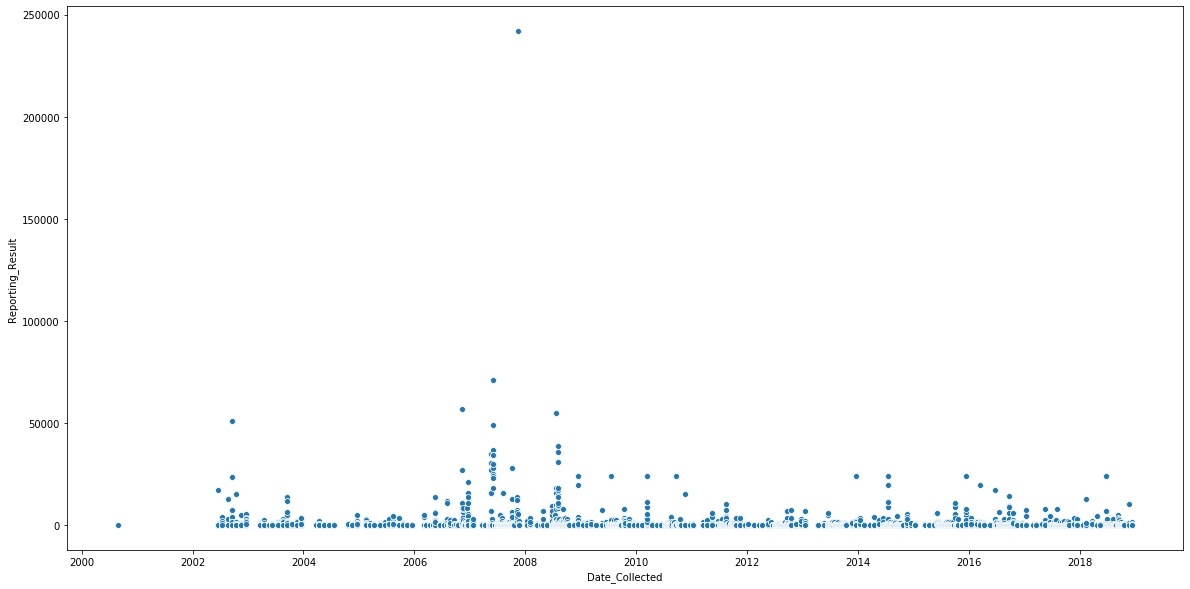

In [84]:
# takes 30sec to run
plt.figure(figsize=(20,10))
# sns.lineplot(x='Date_Collected', y='Reporting_Result', data = e_coli)
sns.scatterplot(x='Date_Collected', y='Reporting_Result', data = e_coli)

plt.show()

Wow, we have some huge values! According to [CRWA's website](https://www.crwa.org/water-quality-data.html), the state water quality standards for swimming are < 126 cfu/100 mL and boating < 630 cfu/100 mL.